# Определение перспективного тарифа для телеком компании

# Описание проекта

Клиентам "Мегалайн" предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Шаг 1. Откройте файл с данными и изучите общую информацию

Откроем файлы, посмотрим, чтов них находится и какой размер данных нас ждет

In [1]:
import pandas as pd

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [2]:
print(calls.info())
print(calls.head())
print(calls.describe())
print(internet.info())
print(internet.head())
print(internet.describe())
print(messages.info())
print(messages.head())
print(messages.describe())
print(tariffs.info())
print(tariffs.head())
print(tariffs.describe())
print(users.info())
print(users.head())
print(users.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000
            duration        user_id
count  202607.000000  202607.000000
mean        6.755887    1253.940619
std         5.843365     144.722751
min         0.000000    1000.000000
25%         1.300000    1126.000000
50%         6.000000    1260.000000
75%        10.700000    1379.000000
max        38.000000    1499.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):

Видим, что в таблицах представлены различные данные у пользователей одной сети. В столбцах имеются 0 значения, в случае с интернетом и звонками мы не должны этого исправлять, т.к. это значит, что звонки могут быть пропущенными (или исходящими не принятыми), а интернет мог быть неиспользован в течение периода.

**Вывод**

В таблицах разные размеры, что может свидетельствовать о том, что в определенные месяцы какие-то функции не использовались людьми. Пустых столбцов нет, а значит, притупаем к подготовке.

## Шаг 2. Подготовьте данные

### Приведем данные к нужным типам ###

In [3]:
internet = internet.drop('Unnamed: 0', 1)
internet['user_id'] = internet['user_id'].astype('str')
calls['user_id'] = calls['user_id'].astype('str')
messages['user_id'] = messages['user_id'].astype('str')
users['user_id'] = users['user_id'].astype('str')

In [4]:
import numpy as np
calls['duration']= calls['duration'].apply(np.ceil).astype('int')
internet['month'] = pd.to_datetime(internet['session_date']).dt.month
pivot_internet = internet.pivot_table(index=['user_id', 'month'], values ='mb_used', aggfunc='sum')
pivot_internet['gb_used'] = (pivot_internet['mb_used']/1024).apply(np.ceil).astype('int')
pivot_internet.head()

mb_used  gb_used
user_id month                   
1000    5       2253.49        3
        6      23233.77       23
        7      14003.64       14
        8      14055.93       14
        9      14568.91       15

In [5]:
calls['month'] = pd.to_datetime(calls['call_date']).dt.month
pivot_calls = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum')
pivot_calls.columns = ['duration_mins']
pivot_calls

duration_mins
user_id month               
1000    5                159
        6                172
        7                340
        8                408
        9                466
...                      ...
1498    10               247
1499    9                 70
        10               449
        11               612
        12               492

[3174 rows x 1 columns]

In [6]:
messages['month'] = pd.to_datetime(messages['message_date']).dt.month
pivot_messages = messages.pivot_table(index=['user_id','month'], values='id', aggfunc='count')
pivot_messages.columns = ['count_messages']
pivot_messages

count_messages
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57
...                       ...
1498    10                 42
1499    9                  11
        10                 48
        11                 59
        12                 66

[2717 rows x 1 columns]

Создали таблицу, в которой видно округленное в большую сторону количество гигабайтов, минут, а также кол-во сообщений и тариф, чтобы было понятно, сколько списали у того или иного человека.

Объединим эти данные в один датафрейм для вычисления месячной абонентской платы.

In [7]:
data = pivot_calls.merge(pivot_messages, on=['user_id','month'], how='outer')
data = data.merge(pivot_internet, on=['user_id','month'], how='outer').fillna(0)
data

duration_mins  count_messages   mb_used  gb_used
user_id month                                                  
1000    5              159.0            22.0   2253.49      3.0
        6              172.0            60.0  23233.77     23.0
        7              340.0            75.0  14003.64     14.0
        8              408.0            81.0  14055.93     14.0
        9              466.0            57.0  14568.91     15.0
...                      ...             ...       ...      ...
1489    9                0.0            32.0  17206.30     17.0
        10               0.0            21.0  19559.44     20.0
        11               0.0            20.0  17491.56     18.0
        12               0.0            35.0  17322.51     17.0
1476    4                0.0             0.0    530.78      1.0

[3214 rows x 4 columns]

Создали таблицу, в которой отобразили помесячно сколько было использовано минут, сообщений и гигабайт Интернета, далее необходимо понять, сколько было заплачено в месяц. 

In [8]:
data1 = users.copy()
data1

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [9]:
data1 = data1.drop(['age','churn_date','first_name','last_name','reg_date'],axis=1)

In [10]:
data = data.merge(data1, on='user_id')
data

,user_id,duration_mins,count_messages,mb_used,gb_used,city,tariff
0,1000,159.0,22.0,2253.49,3.0,Краснодар,ultra
1,1000,172.0,60.0,23233.77,23.0,Краснодар,ultra
2,1000,340.0,75.0,14003.64,14.0,Краснодар,ultra
3,1000,408.0,81.0,14055.93,14.0,Краснодар,ultra
4,1000,466.0,57.0,14568.91,15.0,Краснодар,ultra
...,...,...,...,...,...,...,...
3209,1489,0.0,17.0,11050.56,11.0,Санкт-Петербург,smart
3210,1489,0.0,32.0,17206.30,17.0,Санкт-Петербург,smart
3211,1489,0.0,21.0,19559.44,20.0,Санкт-Петербург,smart
3212,1489,0.0,20.0,17491.56,18.0,Санкт-Петербург,smart


In [11]:
pd.options.mode.chained_assignment = None
data['montly'] = 0
for i in range(len(data)):
    if data['tariff'][i] == 'ultra':
        data['montly'][i] +=1950
        if data['duration_mins'][i] > 3000:
            data['montly'][i] += data['duration_mins'][i] -3000
        if data['count_messages'][i] > 1000:
            data['montly'][i] += data['count_messages'][i] -1000
        if data['gb_used'][i] > 30:
            data['montly'][i] += (data['gb_used'][i]-30)*150
    else:
        data['montly'][i] +=550
        if data['duration_mins'][i] > 500:
            data['montly'][i] += (data['duration_mins'][i]-500)*3
        if data['count_messages'][i] > 50:
            data['montly'][i] += (data['count_messages'][i] -50)*3
        if data['gb_used'][i] > 15:
            data['montly'][i] += (data['gb_used'][i]-15)*200

In [12]:
data

,user_id,duration_mins,count_messages,mb_used,gb_used,city,tariff,montly
0,1000,159.0,22.0,2253.49,3.0,Краснодар,ultra,1950
1,1000,172.0,60.0,23233.77,23.0,Краснодар,ultra,1950
2,1000,340.0,75.0,14003.64,14.0,Краснодар,ultra,1950
3,1000,408.0,81.0,14055.93,14.0,Краснодар,ultra,1950
4,1000,466.0,57.0,14568.91,15.0,Краснодар,ultra,1950
...,...,...,...,...,...,...,...,...
3209,1489,0.0,17.0,11050.56,11.0,Санкт-Петербург,smart,550
3210,1489,0.0,32.0,17206.30,17.0,Санкт-Петербург,smart,950
3211,1489,0.0,21.0,19559.44,20.0,Санкт-Петербург,smart,1550
3212,1489,0.0,20.0,17491.56,18.0,Санкт-Петербург,smart,1150


Посчитали сколько каждый пользователь заплатил в каждом месяце.

## Шаг 3. Проанализируйте данные

Посчитаем среднее по всем услугам тарифа, а также вычислим дисперсию и среднее отклонение.

In [13]:
new_data = data.pivot_table(index='tariff', values=['duration_mins','count_messages','gb_used'])

In [14]:
new_data

,count_messages,duration_mins,gb_used
tariff,,,
smart,33.384029,417.934948,16.328847
ultra,49.363452,526.623350,19.494416


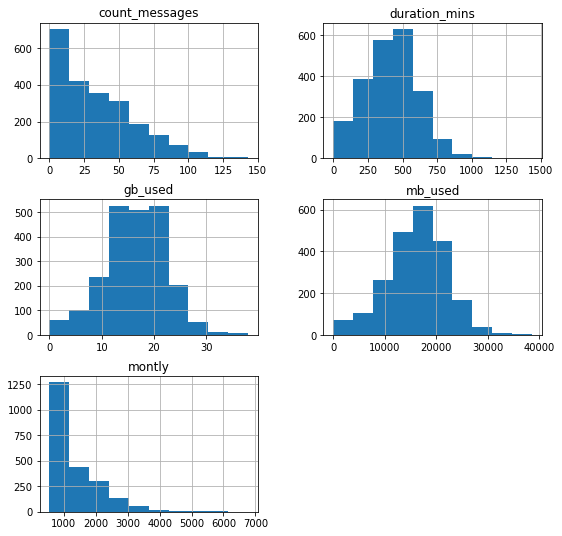

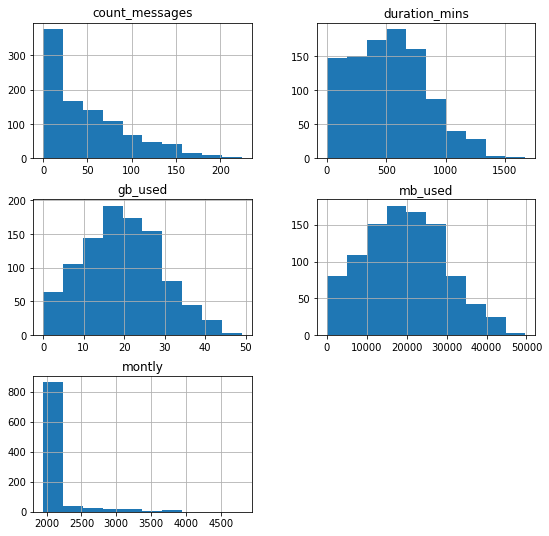

In [15]:
import matplotlib.pyplot as plt
data.groupby('tariff').hist(figsize=(9,9))
plt.show()

In [16]:
data

,user_id,duration_mins,count_messages,mb_used,gb_used,city,tariff,montly
0,1000,159.0,22.0,2253.49,3.0,Краснодар,ultra,1950
1,1000,172.0,60.0,23233.77,23.0,Краснодар,ultra,1950
2,1000,340.0,75.0,14003.64,14.0,Краснодар,ultra,1950
3,1000,408.0,81.0,14055.93,14.0,Краснодар,ultra,1950
4,1000,466.0,57.0,14568.91,15.0,Краснодар,ultra,1950
...,...,...,...,...,...,...,...,...
3209,1489,0.0,17.0,11050.56,11.0,Санкт-Петербург,smart,550
3210,1489,0.0,32.0,17206.30,17.0,Санкт-Петербург,smart,950
3211,1489,0.0,21.0,19559.44,20.0,Санкт-Петербург,smart,1550
3212,1489,0.0,20.0,17491.56,18.0,Санкт-Петербург,smart,1150


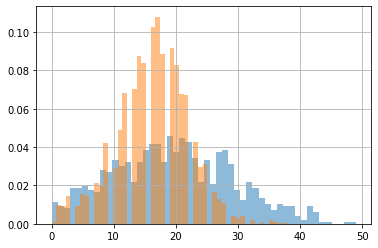

In [17]:
def function(data, column1, column2):
    new_data = data.loc[data[column2]=='ultra']
    new_data[column1].hist(density=True, alpha=0.5,bins=50)
    new_data1 = data.loc[data[column2]=='smart']
    new_data1[column1].hist(density=True, alpha=0.5, bins=50)
function(data, 'gb_used', 'tariff')

In [1]:
for column in ['duration_mins', 'count_messages', 'gb_used']:
    fig = plt.figure(figsize=(10, 5))
    plt.hist(data[data['tariff'] == 'smart'][column], bins=30, label='smart', alpha=0.5, color='black')
    plt.hist(data[data['tariff'] == 'ultra'][column], bins=30, label='ultra', alpha=0.5, color='red')
    plt.grid()
    plt.ylabel('Частота')
    plt.xlabel(f'Значение {column}')
    plt.title(f'График распределения по столбцу {column}', fontsize=14)
    plt.legend()
    plt.show()

NameError: name 'plt' is not defined

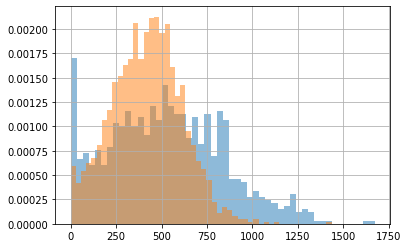

In [18]:
function(data, 'duration_mins', 'tariff')

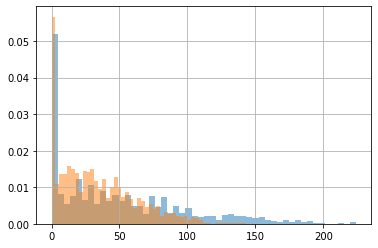

In [19]:
function(data, 'count_messages', 'tariff')

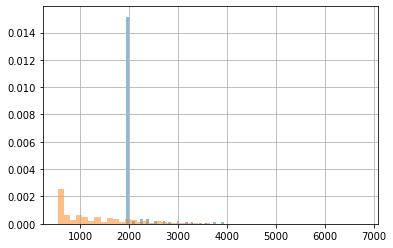

In [20]:
function(data, 'montly', 'tariff')

Посчитали среднее для каждого тарифа: в среднем пользователи тарифа "ультра" используют больше трафика, минут и сообщений, но не критично больше, согласно среднему

In [21]:
var = data.groupby('tariff').var(ddof=1)
var

,duration_mins,count_messages,mb_used,gb_used,montly
tariff,,,,,
smart,36219.315784,796.812958,3.446250e+07,33.028705,669785.708006
ultra,100873.633397,2285.266143,1.017510e+08,97.091686,141516.745079


Видим дисперсию, вычисленную по выборке, следующим шагом будем искать стандартное отклонение.

In [23]:
std = data.groupby('tariff').std()
std

,duration_mins,count_messages,mb_used,gb_used,montly
tariff,,,,,
smart,190.313730,28.227876,5870.476681,5.747061,818.404367
ultra,317.606098,47.804457,10087.170752,9.853511,376.187114


Нашли стандартное отклонение

## Шаг 4. Проверьте гипотезы

Сформулируем нулевую гипотезу так: "средняя выручка пользователей тарифов «Ультра» и «Смарт» равны" и проверим ее. Альтернативная гипотеза будет звучать так: "средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются"

In [24]:
from scipy import stats as st

In [25]:
ultra = data.loc[data['tariff'] == 'ultra']
smart = data.loc[data['tariff'] == 'smart']

In [26]:
results = st.ttest_ind(ultra['montly'], smart['montly'])
print('p-значение: ', results.pvalue)
alpha=0.05
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.4229814360764067e-160
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, что может говорить о том, что верто другое: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Сформулируем вторую нулевую гипотезу так: "средняя выручка пользователи из Москвы равна выручке от пользователей из других регионов". Альтренативная: "средняя выручка пользователи из Москвы отличается от выручки от пользователей из других регионов"

In [27]:
moscow = data.loc[data['city']=="Москва"]
other = data.loc[data['city']!="Москва"]

In [28]:
results = st.ttest_ind(moscow['montly'], other['montly'])
print('p-значение: ', results.pvalue)
alpha=0.05
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


Видим, что нулевая гипотеза не отвергнута, что означает тот факт, что может быть, выручка и отличается, а может она такая же, как и в других регионах

Для проверки гипотез использовали критерий ежемесячной платы людей в течение данного периода.

## Шаг 5. Общий вывод

Сделаем общие выводы по работе:

- в данных не было предсталено критических ошибок, поэтому мы изменили типы данных в некоторых таблицах и приступили к следующему шагу
- посчитали, сколько всего тратили люди гигабайт, и минут, и сообщений, а также рассчитали сумму, которую платили пользователи в конце каждого месяца
- нашли среднее, дисперцию и среднее отклонение по данным месячной оплаты
- сделали вывод, что гипотеза о том, что люди с разных тарифов приносят разную выручку - неправда, но отвергнуть гипотезу о том, что люди из Москвы приносят больше денег, отвергнуть не получилось

В целом, можем сделать вывод, что тариф Ультра приносит бОльшую выручку, но люди более активно покупают тариф "смарт", поэтому в целом выручка по тарифу "смарт" больше. 